<a href="https://colab.research.google.com/github/CardosoJr/bootcamp/blob/main/Labs/Lab%204%20-%20Data%20Collection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Collection

Objetivo desse webinar é descrever algumas formas principais de se coletar dados

## SQL

* census_bureau_usa
* iowa_liquor_sales
* covid_19_geographic_distribution_worldwide


In [ ]:
"""
SELECT APPROX_QUANTILES(VARIACAO, 4) QUANTIS

FROM
(SELECT *,
      SAFE_DIVIDE(POPULATION_2010 - POPULATION_2000, POPULATION_2000) as VARIACAO,
FROM

(SELECT a.zipcode,
       a.gender,
       sum(a.population) as POPULATION_2000,
       sum(b.population) as POPULATION_2010

FROM `bigquery-public-data.census_bureau_usa.population_by_zip_2000` a
INNER JOIN `bigquery-public-data.census_bureau_usa.population_by_zip_2010` b on a.zipcode = b.zipcode AND a.gender = b.gender
group by zipcode, gender)

ORDER BY VARIACAO DESC)
"""

In [ ]:
"""
SELECT
  date,
  daily_confirmed_cases,
  AVG(daily_confirmed_cases) OVER (PARTITION BY geo_id ORDER BY date ASC ROWS BETWEEN 7 PRECEDING AND CURRENT ROW) AS MEDIA_MOVEL_7,


FROM `bigquery-public-data.covid19_ecdc.covid_19_geographic_distribution_worldwide`
WHERE date >= "2020-06-01" AND date <= "2020-12-31" AND geo_id = "BR"
ORDER BY date
"""


## Lendo DataFrames diretamente da Web


In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set_style('darkgrid')
# sns.set_context('talk')
sns.set_palette('rainbow')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

### CSVs

In [2]:
population = pd.read_csv("https://raw.githubusercontent.com/datasets/population/master/data/population.csv", sep = ',', on_bad_lines = 'skip')

In [3]:
population.head()

,Country Name,Country Code,Year,Value
0,Aruba,ABW,1960,54608
1,Aruba,ABW,1961,55811
2,Aruba,ABW,1962,56682
3,Aruba,ABW,1963,57475
4,Aruba,ABW,1964,58178


### JSON

#### API do Banco Central do Brasil

Documentação: https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries

In [4]:
bcb_series = {
    'ipca' : 433,
    'igpm' : 189,
    'selic' : 11,
    'meta_selic' : 432,
    'cdi' : 12,
    'pnad' : 24369,
    'cambio' : 1,
    'pib' : 4380
}

def get_data_bcb(series, start, end):
    now = datetime.datetime.now()
    if start is None:
        start = now

    if end is None:
        end = now

    if isinstance(start, str):
        start = datetime.datetime.strptime(start, "%Y-%m-%d")

    if isinstance(end, str):
        end = datetime.datetime.strptime(end, "%Y-%m-%d")

    if start > end:
        raise Exception("Start datetime is greater than end")

    dataInicial = start.strftime("%d/%m/%Y")
    dataFinal = end.strftime("%d/%m/%Y")

    if series.lower() in bcb_series.keys():
        codigo_serie = bcb_series[series.lower()]
    else:
        raise Exception("Series not found")

    url = f"http://api.bcb.gov.br/dados/serie/bcdata.sgs.{codigo_serie}/dados?formato=json&dataInicial={dataInicial}&dataFinal={dataFinal}"

    df = pd.DataFrame([])
    try:
        df = pd.read_json(url)
    except:
        print("Could not load data from bcb. Query string:", url)

    return df


In [5]:
import json

In [6]:
ipca = get_data_bcb('ipca', "2010-01-01", "2022-01-01")

In [7]:
ipca.head()

,data,valor
0,01/01/2010,0.75
1,01/02/2010,0.78
2,01/03/2010,0.52
3,01/04/2010,0.57
4,01/05/2010,0.43


In [8]:
ipca['data'] = pd.to_datetime(ipca['data'], format = "%d/%m/%Y")

Vamos fazer a soma dos últimos 12 meses para calcular o IPCA acumulado (assim como aparece nas notícias). Fazemos isso em SQL da seguinte forma:

`SUM(IPCA) OVER (ORDER BY data ASC ROWS BETWEEN 12 PRECEDING AND CURRENT ROW)`

In [9]:
ipca['ipca_ac'] = ipca['valor'].rolling(12).sum()

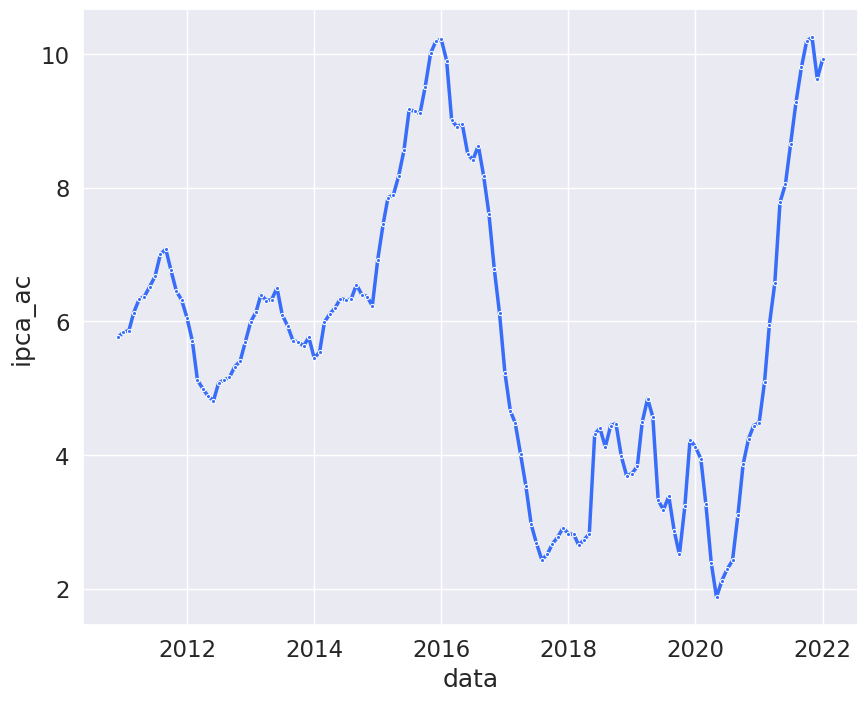

In [13]:
fig, ax = plt.subplots(figsize = (10,8))
sns.lineplot(x = ipca['data'], y = ipca['ipca_ac'], data = ipca, ax = ax, marker = '.');

## Chamando APIs

### Google News

In [ ]:
!pip install gnews

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 188 kB 5.3 MB/s 
     |████████████████████████████████| 115 kB 32.6 MB/s 
     |████████████████████████████████| 81 kB 7.0 MB/s 
     |████████████████████████████████| 62 kB 744 kB/s 
     |████████████████████████████████| 508 kB 12.2 MB/s 
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6066 sha256=1c6abee3c53543691501a412a9bf22720d1b272ec9295b74e1b37f8ae975f608
  Stored in directory: /root/.cache/pip/wheels/73/ad/a4/0dff4a6ef231fc0dfa12ffbac2a36cebfdddfe059f50e019aa
Successfully built sgmllib3k
  Attempting uninstall: charset-normalizer
    Found existing installation: charset-normalizer 2.1.1
    Uninstalling charset-normalizer-2.1.1:
      Successfully uninstalled charset-normalizer-2.1.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-

In [ ]:
from gnews import GNews

In [ ]:
gnews = GNews(language = "EN", country = "US", period = "7d")
news = gnews.get_news("world cup")

In [ ]:
news

[{'title': 'World Cup predictions: Soccer broadcasters make their picks - World Soccer Talk',
  'description': 'World Cup predictions: Soccer broadcasters make their picks  World Soccer Talk',
  'published date': 'Sat, 19 Nov 2022 08:00:00 GMT',
  'url': 'https://worldsoccertalk.com/news/world-cup-predictions-soccer-broadcasters-make-their-picks-20221110-WST-406704.html',
  'publisher': {'href': 'https://worldsoccertalk.com',
   'title': 'World Soccer Talk'}},
 {'title': 'Qatar made history in Ecuador match: Why there’s nothing to be proud of | Mint - Mint',
  'description': 'Qatar made history in Ecuador match: Why there’s nothing to be proud of | Mint  Mint',
  'published date': 'Mon, 21 Nov 2022 06:16:14 GMT',
  'url': 'https://www.livemint.com/news/world/qatar-made-history-in-fifa-world-cup-2022-match-against-ecuador-but-there-s-nothing-to-be-proud-of-11669008637170.html',
  'publisher': {'href': 'https://www.livemint.com', 'title': 'Mint'}},
 {'title': 'Who is Tim Weah? Inside the

In [ ]:
pd.DataFrame(news)

,title,description,published date,url,publisher
0,World Cup predictions: Soccer broadcasters mak...,World Cup predictions: Soccer broadcasters mak...,"Sat, 19 Nov 2022 08:00:00 GMT",https://worldsoccertalk.com/news/world-cup-pre...,"{'href': 'https://worldsoccertalk.com', 'title..."
1,Qatar made history in Ecuador match: Why there...,Qatar made history in Ecuador match: Why there...,"Mon, 21 Nov 2022 06:16:14 GMT",https://www.livemint.com/news/world/qatar-made...,"{'href': 'https://www.livemint.com', 'title': ..."
2,Who is Tim Weah? Inside the USMNT World Cup ro...,Who is Tim Weah? Inside the USMNT World Cup ro...,"Tue, 22 Nov 2022 12:40:21 GMT",https://www.foxsports.com/stories/soccer/usmnt...,"{'href': 'https://www.foxsports.com', 'title':..."
3,The saddest moments in World Cup history - 90m...,The saddest moments in World Cup history 90mi...,"Wed, 09 Nov 2022 08:00:00 GMT",https://www.90min.com/posts/the-saddest-moment...,"{'href': 'https://www.90min.com', 'title': '90..."
4,Americans kick off the World Cup: US fans pack...,Americans kick off the World Cup: US fans pack...,"Mon, 21 Nov 2022 08:00:00 GMT",https://www.dailymail.co.uk/sport/football/art...,"{'href': 'https://www.dailymail.co.uk', 'title..."
5,Who We’ll Be Watching This World Cup: The Ital...,Who We’ll Be Watching This World Cup: The Ital...,"Sun, 20 Nov 2022 08:00:00 GMT",https://www.chiesaditotti.com/2022/11/20/23467...,"{'href': 'https://www.chiesaditotti.com', 'tit..."
6,World Cup 2022 Squads: All 832 players heading...,World Cup 2022 Squads: All 832 players heading...,"Sun, 20 Nov 2022 08:00:00 GMT",https://www.mirror.co.uk/sport/football/news/w...,"{'href': 'https://www.mirror.co.uk', 'title': ..."
7,France: William Saliba wants to emulate Thierr...,France: William Saliba wants to emulate Thierr...,"Thu, 10 Nov 2022 08:00:00 GMT",https://www.dailymail.co.uk/sport/football/art...,"{'href': 'https://www.dailymail.co.uk', 'title..."
8,Jack Wilshere gets the last laugh with Bukayo ...,Jack Wilshere gets the last laugh with Bukayo ...,"Mon, 21 Nov 2022 08:00:00 GMT",https://www.mirror.co.uk/sport/football/news/w...,"{'href': 'https://www.mirror.co.uk', 'title': ..."
9,VAR and peace? Why tech-assisted refereeing wo...,VAR and peace? Why tech-assisted refereeing wo...,"Fri, 18 Nov 2022 08:00:00 GMT",https://theconversation.com/var-and-peace-why-...,"{'href': 'https://theconversation.com', 'title..."


### Yahoo Finance

In [ ]:
!pip install yahooquery

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 1.8 MB/s 


In [ ]:
from yahooquery import Ticker

In [ ]:
ticker = Ticker("AAPL")
data = ticker.history(start = "2020-01-01", end = "2022-01-01", interval = '1d')

In [ ]:
data = data.reset_index()

In [ ]:
data.head()

,symbol,date,high,volume,low,open,close,adjclose,dividends,splits
0,AAPL,2020-01-02,75.150002,135480400,73.797501,74.059998,75.087502,73.561531,0.0,0.0
1,AAPL,2020-01-03,75.144997,146322800,74.125000,74.287498,74.357498,72.846375,0.0,0.0
2,AAPL,2020-01-06,74.989998,118387200,73.187500,73.447502,74.949997,73.426819,0.0,0.0
3,AAPL,2020-01-07,75.224998,108872000,74.370003,74.959999,74.597504,73.081497,0.0,0.0
4,AAPL,2020-01-08,76.110001,132079200,74.290001,74.290001,75.797501,74.257103,0.0,0.0


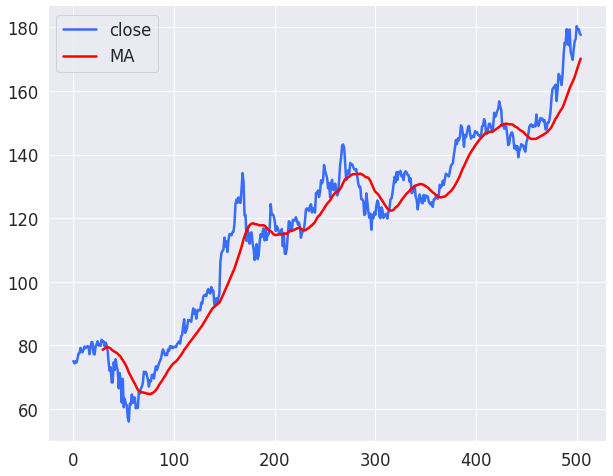

In [ ]:
fig, ax = plt.subplots(figsize = (10, 8))
ax.plot(data['close'], label = 'close')
ax.plot(data['close'].rolling(30).mean(), color = 'red', label = 'MA')
plt.legend()
sns.despine()

### COVID

Documentação: https://documenter.getpostman.com/view/10808728/SzS8rjbc#00030720-fae3-4c72-8aea-ad01ba17adf8

In [ ]:
import requests

In [ ]:
population = population[population['Year'] == population['Year'].max()]
population.rename(columns = {'Country Name' : 'Country'}, inplace = True)

In [ ]:
countries_url = "https://api.covid19api.com/countries"

response = requests.request("GET", countries_url)
data = response.json()
countries = pd.DataFrame(data)

url = "https://api.covid19api.com/dayone/country/south-africa/status/confirmed"



In [ ]:
countries = pd.merge(left = countries, right = population, on = 'Country')

In [ ]:
countries.isna().mean()

Country         0.0
Slug            0.0
ISO2            0.0
Country Code    0.0
Year            0.0
Value           0.0
dtype: float64

In [ ]:
biggest_countries = countries.sort_values(by = 'Value', ascending = False).head(10)['Slug'].values

In [ ]:
biggest_countries

array(['china', 'india', 'indonesia', 'pakistan', 'brazil', 'nigeria',
       'bangladesh', 'russia', 'japan', 'mexico', 'ethiopia',
       'philippines', 'germany', 'turkey', 'thailand', 'france',
       'united-kingdom', 'italy', 'south-africa', 'myanmar'], dtype=object)

In [ ]:
from tqdm import tqdm
import time

In [ ]:
headers = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770.142 Safari/537.36'}

In [ ]:
dfs = []
for country in tqdm(biggest_countries):
  confirmed_url = f"https://api.covid19api.com/dayone/country/{country}/status/confirmed"
  response = requests.request("GET", confirmed_url, headers = headers)
  data = response.json()
  try:
    dfs.append(pd.DataFrame(data))
  except Exception as e:
    print(e)
    print(country, data)
  time.sleep(0.5)

covid = pd.concat(dfs, ignore_index = True)

In [ ]:
confirmed_url

'https://api.covid19api.com/dayone/country/china/status/deaths'

In [ ]:
covid.head()

,Country,CountryCode,Province,City,CityCode,Lat,Lon,Cases,Status,Date
0,China,CN,Hubei,,,30.98,112.27,444,confirmed,2020-01-22 00:00:00+00:00
1,China,CN,Shanxi,,,37.58,112.29,1,confirmed,2020-01-22 00:00:00+00:00
2,China,CN,Henan,,,33.88,113.61,5,confirmed,2020-01-22 00:00:00+00:00
3,China,CN,Jiangxi,,,27.61,115.72,2,confirmed,2020-01-22 00:00:00+00:00
4,China,CN,Shandong,,,36.34,118.15,2,confirmed,2020-01-22 00:00:00+00:00


In [ ]:
covid['Date'] = pd.to_datetime(covid['Date'])

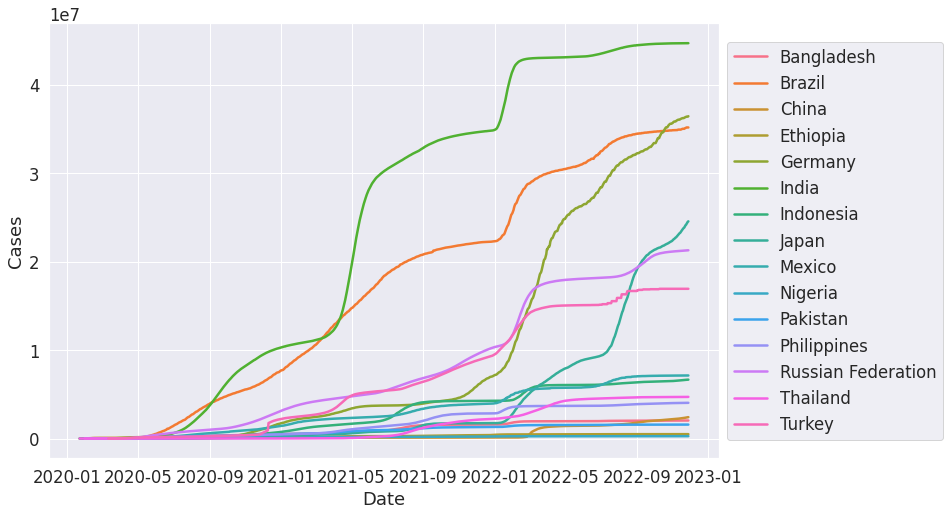

In [ ]:
covid_country = covid.groupby(['Country', 'Date'])['Cases'].sum().reset_index()

fig, ax = plt.subplots(figsize = (12,8))
sns.lineplot('Date', 'Cases', hue = 'Country', data = covid_country, ax = ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [ ]:
covid = pd.merge(left = covid, right = countries, on = ['Country'], how = 'left')

In [ ]:
covid.head()

,Country,CountryCode,Province,City,CityCode,Lat,Lon,Cases,Status,Date,Slug,ISO2,Country Code,Year,Value
0,China,CN,Hubei,,,30.98,112.27,444,confirmed,2020-01-22 00:00:00+00:00,china,CN,CHN,2018,1392730000
1,China,CN,Shanxi,,,37.58,112.29,1,confirmed,2020-01-22 00:00:00+00:00,china,CN,CHN,2018,1392730000
2,China,CN,Henan,,,33.88,113.61,5,confirmed,2020-01-22 00:00:00+00:00,china,CN,CHN,2018,1392730000
3,China,CN,Jiangxi,,,27.61,115.72,2,confirmed,2020-01-22 00:00:00+00:00,china,CN,CHN,2018,1392730000
4,China,CN,Shandong,,,36.34,118.15,2,confirmed,2020-01-22 00:00:00+00:00,china,CN,CHN,2018,1392730000


In [ ]:
covid['Cases_per_100k'] = covid['Cases'] * 100000 / covid['Value']

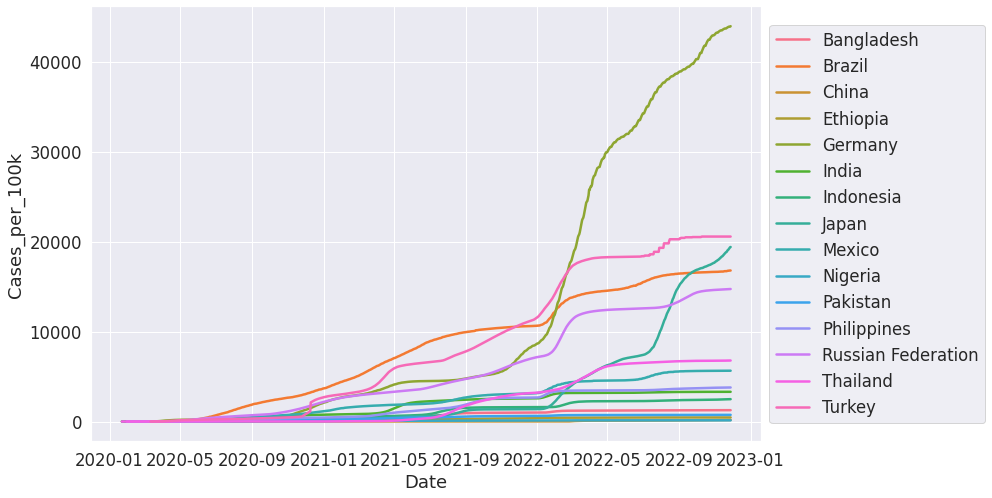

In [ ]:
covid_country = covid.groupby(['Country', 'Date'])['Cases_per_100k'].sum().reset_index()

fig, ax = plt.subplots(figsize = (12,8))
sns.lineplot('Date', 'Cases_per_100k', hue = 'Country', data = covid_country, ax = ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

### Reddit

In [23]:
!pip install praw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 2.5 MB/s eta 0:00:00


In [25]:
import praw

In [26]:
with open(Path("config.yaml"), 'r') as f:
    config = yaml.safe_load(f)

reddit = praw.Reddit(client_id = config['reddit_client_id'],
                    client_secret = config['reddit_secret'],
                    user_agent = config['reddit_user_agent'])

In [30]:
posts = reddit.subreddit('wallstreetbets').search("GME", limit = 10)
posts = [x for x in posts]

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



In [31]:
len(posts)

10

In [33]:
posts[0].url

'https://www.reddit.com/r/wallstreetbets/comments/11xxru4/gme_gamestop_earnings_lets_take_a_closer_look/'

In [34]:
posts[0].num_comments

1304

In [35]:
post = reddit.submission(url=posts[0].url)
body = []
scores = []
post.comments.replace_more(limit=0)
for c in post.comments:
    scores.append(c.score)
    body.append(c.body)

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



In [37]:
body

['Stop reporting this post. We will allow it, cause it is finally something new in GME story.',
 'Fuck. It’s up 48% after hours',
 'Ha. GameStop has enough cash to buy Credit suise 😂',
 'Wait hold up is this company profitable now ?!',
 'So do I buy now. Since I missed out',
 "I've been edging for over 2 years.  I'm gonna bust.",
 'You can tell we’ve reached the end times by the way banks are failing, Bitcoin is sprinting, and GME is beating estimates and it’s all happening at the same time as the Fed has to weigh the decision to let inflation run rampant or murder the jobs market 🤑🤑🤑',
 'If it ends up 30+ this week I will make 26k on 500 investment',
 'So you are basically saying we will moon this week?',
 'just saw the news, i was going to buy $5700 worth of gme earlier today, but i bitched out. Scared money don’t make money',
 '[deleted]',
 'Cash on hand is honestly  very impressive. All Jokes aside, the company is in a healthy state. Minimal debt and alor of cash..',
 "Calling gran

In [39]:
reddit_comments = pd.DataFrame({'text' : body, 'score' : scores})
reddit_comments.head()

,text,score
0,"Stop reporting this post. We will allow it, ca...",1
1,Fuck. It’s up 48% after hours,1294
2,Ha. GameStop has enough cash to buy Credit sui...,10896
3,Wait hold up is this company profitable now ?!,2713
4,So do I buy now. Since I missed out,1959


In [49]:
import re

def cleaning_tweets(text):
    whitespace = re.compile(r"\s+")
    user = re.compile(r"(?i)@[a-z0-9_]+")
    user_reddit = re.compile(r"(?i)u/[a-z0-9_]+")

    text = whitespace.sub(" ", text)
    text = user.sub("", text)
    text = user_reddit.sub("", text)
    text = text.replace("\n", " ")
    # text = re.sub('\[.*?\]', '', text)
    # text = re.sub('<.*?>+', '', text)
    text = re.sub(r"https?\S+", "", text)
    text = re.sub(r"&.*?;", "", text)
    text = re.sub(r"<.*?>", "", text)
    # text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = text.replace("RT", "")
    text = text.replace(u"…", "")
    text = text.strip()

    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F700-\U0001F77F"  # alchemical symbols
        u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA00-\U0001FA6F"  # Chess Symbols
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U00002702-\U000027B0"  # Dingbats
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE
    )
    text = emoji_pattern.sub(r'', text)
    return text


reddit_comments['text'] = reddit_comments['text'].apply(cleaning_tweets)

In [48]:
print(reddit_comments.iloc[-1].values)

['P stoked. Haven’t checked my shares much since the aftermath of the great short squeeze. I bought as high as what is $78 now '
 1]


#### Análise de Sentimentos

In [ ]:
!pip install transformers

In [51]:
!pip install sentencepiece


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.6 MB/s eta 0:00:00


In [52]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import MarianTokenizer, MarianMTModel
from scipy.special import softmax

In [53]:
task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
sent_tokenizer = AutoTokenizer.from_pretrained(MODEL)
sent_model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [55]:
text_to_predict = reddit_comments['text'].ravel().tolist()

In [56]:
encoded_input = sent_tokenizer(text_to_predict, return_tensors='pt', padding = True)
output = sent_model(**encoded_input)
scores = output[0].detach().numpy()
scores = softmax(scores, axis = 1)
reddit_comments[['Negative', "Neutral", "Positive"]] = scores

In [57]:
reddit_comments.head()

,text,score,Negative,Neutral,Positive
0,"Stop reporting this post. We will allow it, ca...",1,0.124002,0.618691,0.257307
1,Fuck. It’s up 48% after hours,1294,0.841406,0.131210,0.027384
2,Ha. GameStop has enough cash to buy Credit suise,10896,0.095300,0.688606,0.216094
3,Wait hold up is this company profitable now ?!,2713,0.281475,0.658845,0.059680
4,So do I buy now. Since I missed out,1959,0.616456,0.355667,0.027877


### Twitter

A partir da mudança para X, agora não é possível mais recuperar tweets de graça

Por isso, o código abaixo agora só funciona é só para ilustração

In [14]:
import yaml
import requests
import json
from datetime import datetime
from pathlib import Path


In [19]:
with open(Path("config.yaml"), 'r') as f:
  config = yaml.safe_load(f)

bearer_token = config['twitter_token']
all_url = "https://api.twitter.com/2/tweets/search/all"
recent_url = "https://api.twitter.com/2/tweets/search/recent"

def create_headers(bearer_token):
  headers = {"Authorization": "Bearer {}".format(bearer_token)}
  return headers

def connect_to_endpoint(url, headers, params, encoding = "ISO-8859-1"):
  response = requests.request("GET", url, headers=headers, params=params)
  if response.status_code != 200:
      raise Exception(response.status_code, response.text)
  return response.json()

In [20]:
import datetime
from dateutil.relativedelta import relativedelta

end = datetime.datetime.now(datetime.timezone.utc) - relativedelta(days = 1)
begin = end - relativedelta(days = 5)

In [22]:
max_count = 10
from_date = begin.isoformat()
to_date = end.isoformat()
filters = "World Cup"

params = {
    "query": fr"(\{filters}) (lang:en)",
    "tweet.fields": "created_at,lang,author_id,public_metrics",
}

if max_count:
    params['max_results'] = str(max_count)
if from_date:
    params["start_time"] = from_date
if to_date:
    params["end_time"] = to_date

headers = create_headers(bearer_token)
json_response = connect_to_endpoint(recent_url, headers, params)

for d in json_response['data']:
    d['reply_count'] = d['public_metrics']['reply_count']
    d['like_count'] = d['public_metrics']['like_count']
    d['quote_count'] = d['public_metrics']['quote_count']
    d['retweet_count'] = d['public_metrics']['retweet_count']
    d.pop('public_metrics', 'None')

df = pd.DataFrame(json_response['data'])

In [ ]:
df.head()

,text,created_at,edit_history_tweet_ids,lang,id,author_id,reply_count,like_count,quote_count,retweet_count
0,RT @timurkuran: A Party that locks down people...,2022-11-28T22:33:57.000Z,[1597358161870352384],en,1597358161870352384,1192915579553927168,0,0,0,130
1,@andy_murray @piersmorgan @Cristiano @B_Fernan...,2022-11-28T22:33:57.000Z,[1597358161635135491],en,1597358161635135491,1551089089889419264,0,0,0,0
2,RT @brfootball: Ghana and Uruguay will meet in...,2022-11-28T22:33:57.000Z,[1597358161027293184],en,1597358161027293184,517068220,0,0,0,1239
3,"@CLMWSN_10 @LBC No, we can't. Football's World...",2022-11-28T22:33:57.000Z,[1597358160427507714],en,1597358160427507714,1109211367989563392,1,1,0,0
4,RT @DanielRegha: Ghana is the first African te...,2022-11-28T22:33:57.000Z,[1597358159911612417],en,1597358159911612417,2475701906,0,0,0,959


In [ ]:
import re

def cleaning_tweets(text):
    whitespace = re.compile(r"\s+")
    user = re.compile(r"(?i)@[a-z0-9_]+")
    user_reddit = re.compile(r"(?i)u/[a-z0-9_]+")

    text = whitespace.sub(" ", text)
    text = user.sub("", text)
    text = user_reddit.sub("", text)
    text = text.replace("\n", " ")
    # text = re.sub('\[.*?\]', '', text)
    # text = re.sub('<.*?>+', '', text)
    text = re.sub(r"https?\S+", "", text)
    text = re.sub(r"&.*?;", "", text)
    text = re.sub(r"<.*?>", "", text)
    # text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = text.replace("RT", "")
    text = text.replace(u"…", "")
    text = text.strip()
    return text


df['text'] = df['text'].apply(cleaning_tweets)

In [ ]:
df.head()

,text,created_at,edit_history_tweet_ids,lang,id,author_id,reply_count,like_count,quote_count,retweet_count
0,: A Party that locks down people indefinitely ...,2022-11-28T22:33:57.000Z,[1597358161870352384],en,1597358161870352384,1192915579553927168,0,0,0,130
1,Ghana beats south Korea 3-2 to record first wi...,2022-11-28T22:33:57.000Z,[1597358161635135491],en,1597358161635135491,1551089089889419264,0,0,0,0
2,: Ghana and Uruguay will meet in an important ...,2022-11-28T22:33:57.000Z,[1597358161027293184],en,1597358161027293184,517068220,0,0,0,1239
3,"No, we can't. Football's World Cup offers a gl...",2022-11-28T22:33:57.000Z,[1597358160427507714],en,1597358160427507714,1109211367989563392,1,1,0,0
4,: Ghana is the first African team to score goa...,2022-11-28T22:33:57.000Z,[1597358159911612417],en,1597358159911612417,2475701906,0,0,0,959


In [ ]:
df['text'].values

array([': A Party that locks down people indefinitely and keeps them under constant surveillance failed to foresee that images of mas',
       'Ghana beats south Korea 3-2 to record first win at the ongoing world cup In Qatar. YOU CAN WATCH VIDEO of GOALS, ANALYSIS And STATS HERE👇',
       ': Ghana and Uruguay will meet in an important game at the World Cup. Again 🙃',
       "No, we can't. Football's World Cup offers a global platform. It's watched by million across the planet, rich and poor. Of course people will use it to highlight their cause. Specially against the background of Fifa corruption and Qatar's dismal human rights record.",
       ': Ghana is the first African team to score goals in the 2022 World Cup,  against a strong contender (Portugal); The Black S',
       ': Richarlison on hooking up with Anitta: “Bro, I did not get her. But if she wants it, I want it. After I win the World Cup,',
       ": Confused about what's going on between the U.S. and Iranian teams ahead of

#### Análise de Sentimentos

In [50]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.6 MB/s eta 0:00:00


In [ ]:
!pip install sentencepiece


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 5.2 MB/s 


In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import MarianTokenizer, MarianMTModel
from scipy.special import softmax

In [ ]:
task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
sent_tokenizer = AutoTokenizer.from_pretrained(MODEL)
sent_model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
text_to_predict = df['text'].ravel().tolist()

In [ ]:
text_to_predict

[': A Party that locks down people indefinitely and keeps them under constant surveillance failed to foresee that images of mas',
 'Ghana beats south Korea 3-2 to record first win at the ongoing world cup In Qatar. YOU CAN WATCH VIDEO of GOALS, ANALYSIS And STATS HERE👇',
 ': Ghana and Uruguay will meet in an important game at the World Cup. Again 🙃',
 "No, we can't. Football's World Cup offers a global platform. It's watched by million across the planet, rich and poor. Of course people will use it to highlight their cause. Specially against the background of Fifa corruption and Qatar's dismal human rights record.",
 ': Ghana is the first African team to score goals in the 2022 World Cup,  against a strong contender (Portugal); The Black S',
 ': Richarlison on hooking up with Anitta: “Bro, I did not get her. But if she wants it, I want it. After I win the World Cup,',
 ": Confused about what's going on between the U.S. and Iranian teams ahead of tomorrow's match?  has an expla",
 ': Fra

In [ ]:
encoded_input = sent_tokenizer(text_to_predict, return_tensors='pt', padding = True)
output = sent_model(**encoded_input)
scores = output[0].detach().numpy()
scores = softmax(scores, axis = 1)
df[['Negative', "Neutral", "Positive"]] = scores

In [ ]:
df[['text', 'Negative', "Neutral", "Positive"]].head(10)

,text,Negative,Neutral,Positive
0,: A Party that locks down people indefinitely ...,0.921749,0.075347,0.002904
1,Ghana beats south Korea 3-2 to record first wi...,0.006700,0.526565,0.466735
2,: Ghana and Uruguay will meet in an important ...,0.074159,0.652045,0.273796
3,"No, we can't. Football's World Cup offers a gl...",0.267468,0.483198,0.249335
4,: Ghana is the first African team to score goa...,0.004126,0.503759,0.492115
5,": Richarlison on hooking up with Anitta: “Bro,...",0.142303,0.697458,0.160239
6,: Confused about what's going on between the U...,0.303876,0.678571,0.017553
7,": France, Brazil and Portugal have all qualifi...",0.001948,0.281906,0.716146
8,: A man ran into the field during World Cup ma...,0.018652,0.590297,0.391051
9,Joe Rodon cannot wait for the 'brilliant chall...,0.005894,0.125180,0.868927
